# Embedded ML Lab - Excercise 3 - Pruning

In this exercise, we will explore pruning of NNs. The pruning experiments are split in two parts. Firstly, we will explore pruning for compressing the model size. For that, we will drop parameters of the network in an unstructured way. Secondly, we will explore Pruning to speed up NN inference. For that we will use "structured pruning" and conv-layer output channels.

For this lab, we use a little bit heavier version of the previously used `CifarNet`. The implementation can be found in the `net.py` file. Additionally, there are a couple of utility functions in `utils.py`. For the first part of the lab, we will use `net_acc` to measure the accuracy.

In [2]:
import torch
torch.rand(1).to('cuda') #initialize cuda context (might take a while)

from net import CifarNet
import torch
from typing import List, Dict, Tuple

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=False, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import copy

net = CifarNet()
state_dict = torch.load('state_dict__cifarnet.pt')
net.load_state_dict(state_dict)

from utils import net_acc, size_on_disk

print(f"CifarNet Accuracy: {net_acc(CifarNet, state_dict, testloader, batches=128, device='cuda')}%")

CifarNet Accuracy: 85.3%


In [5]:
state_dict.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'fc.weight', 'fc.bias'])

We now explore pruning methods to compress the model size, by setting parameters to zero. We evaluate two methods: Random pruning, and l1-norm pruning.

Your Tasks:
* Implement the function `random_unstructured_pruning`. This function takes a state_dict as input and returns a state_dict with same elements and dimensions as output. Prune (set to zero) a ratio of `prune_ratio` per convolutional layer (filter). The bias can be left untouched, as well as the FC layer.
    * One way to do this to use as mask (e.g., a random torch tensor) where you randomly clip `prune_ratio`to zero and the remainder to one, that you multiply with the convolutional layer's filters.
    
* Implement the function `l1_unstructured_pruning`. Here, instead of randomly pruning parameters to zero, you are supposed to set the parameters that have the lowest magnitude to zero.
    * One way to do something like this is with numpy `percentile` (i.e., check https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)

In [23]:
import numpy as np

def random_unstructured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    for key in state_dict:
        if "weight" not in key or "conv" not in key:
            continue
        tensor = state_dict[key]
        size = torch.numel(tensor)
        zeros = int(size * prune_ratio)
        ones = size - zeros
        zeros = torch.zeros(zeros)
        ones = torch.ones(ones)
        res = torch.cat((ones, zeros))
        randomperm = torch.randperm(size)
        res = res[randomperm]
        state_dict[key] = tensor * torch.reshape(res, tensor.shape)

    return state_dict

def l1_unstructured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    for key in state_dict:
        if "weight" not in key or "conv" not in key:
            continue
        tensor = state_dict[key]
        perc = np.percentile(torch.abs(tensor), prune_ratio * 100)
        tensor = torch.where(torch.abs(tensor) >= perc, tensor, torch.tensor(0, dtype = tensor.dtype))
        state_dict[key] = tensor
    return state_dict

The following code plots the differences between random and l1 pruning. The plot is saved on disk with the filename `size_on_disk.png`

100%|██████████| 15/15 [01:05<00:00,  4.39s/it]


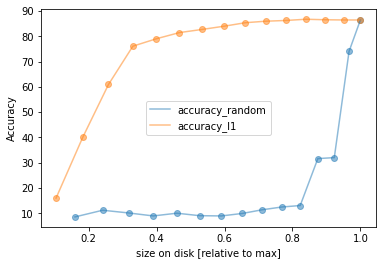

In [24]:
import tqdm
from utils import plot
ratios = [i/15.0 for i in  range(15)]
sd = torch.load('state_dict__cifarnet.pt')
accs_random, size_random = [], []
for ratio in tqdm.tqdm(ratios):
    
    # Apply random unstructured pruning 
    sd_pruned = random_unstructured_pruning(sd, ratio)
    
    # Evaluate accuracy
    accs_random.append(net_acc(CifarNet, sd_pruned, testloader, batches=32, device='cuda'))
    
    # Evaluate size of network on disk (gzip)
    size_random.append(size_on_disk(sd_pruned)[0])
    
accs_l1, size_l1 = [], []
for ratio in tqdm.tqdm(ratios):
    # Apply L1 unstructued pruning
    sd_pruned = l1_unstructured_pruning(sd, ratio)
    accs_l1.append(net_acc(CifarNet, sd_pruned, testloader, batches=32, device='cuda'))
    size_l1.append(size_on_disk(sd_pruned)[0])

    
plot([(size_random, accs_random, 'accuracy_random'),
      (size_l1, accs_l1, 'accuracy_l1')],
      xlabel='size on disk [relative to max]', save_path='size_on_disk.png')